In [6]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
import os
import glob
import torch
from theoretical_analysis.nonnegative_pca_analysis import c_critical
from learning_from_data.train import NNTrainingModule
from scipy.interpolate import interp1d
import scipy.optimize as spo

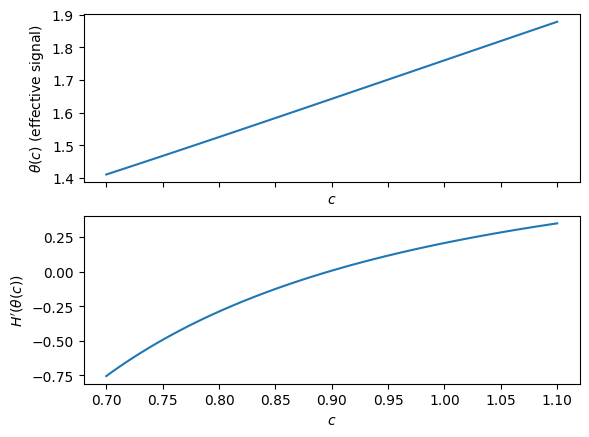

0.8973624933380051

In [ ]:
sigma = lambda x: np.tanh(x)
c_critical(c_range=[0.7, 1.1], sigma=sigma, sigma_image=[-1, 1], plot=True)

# Blackbox optimization on piecewise linear families

In [2]:
def sigma_fn(beta):
    if isinstance(beta, list):
        beta = np.array(beta)
    n = (len(beta) - 3) // 2
    a, b = beta[0 : n + 2], beta[n + 2 :]
    assert (a[1:] >= 0).all()
    assert (b >= 0).all()
    x = np.cumsum(a)
    x = np.concatenate(([-np.inf], x, [np.inf]))
    y = np.cumsum(b)
    y = np.concatenate(([0, 0], y, [y[-1]]))
    image = [0, b.sum()]
    return interp1d(x, y, kind="linear"), image


def c_for_piecewise_linear_function(beta, plot=False):
    """
    Given parameter for the parametrized sigma function, compute c_critical.
    beta = (a[0], a[1], ..., a[n+1], b[0], ..., b[n])
    Define sigma to be a piecewise linear function parametrized by:
    f(x) = y[i] at x[i]
    x = (a[0], a[0]+a[1], ..., a[0] +... +a[n+1]
    y = (0, b[0], b[0]+b[1], ..., b[0] + ... + b[n]
    """
    sigma, image = sigma_fn(beta)
    c = c_critical([0.3, 1.2], sigma=sigma, sigma_image=image, plot=plot)
    return c

In [3]:
def minimize_with_random_initial_simplex(n=20, seed=0):
    # define bounds for the parameters in optimization
    bounds = (
        [(None, None)] + [(0, None) for _ in range(1, n + 2)] + [(0, None) for _ in range(0, n + 1)]
    )
    # define initial simplex for Nelder-Mead
    rng = np.random.default_rng(seed)
    N = 2 * n + 3  # N parameters, need N+1 points to define the initial simplex
    simplex = rng.uniform(
        0, 1, (N + 1, N)
    )  # set each incremental parameter to be uniformly random in [0,1]
    simplex[:, 0] = rng.uniform(
        -5, 0, N + 1
    )  # set x0(the first parameter) to be uniformly random in [-5,0]
    # run minimization
    historic_xks = []
    historic_funs = []

    def callback_function(intermediate_result):
        historic_xks.append(intermediate_result.x)
        historic_funs.append(intermediate_result.fun)

    res = spo.minimize(
        c_for_piecewise_linear_function,
        x0=np.zeros(2 * n + 3),
        method="Nelder-Mead",
        bounds=bounds,
        callback=callback_function,
        options={"initial_simplex": simplex},
    )
    return historic_xks, historic_funs, res

In [ ]:
for seed in range(10):
    historic_xks, historic_funs, res = minimize_with_random_initial_simplex(n=15, seed=seed)
    if res.fun < 0.8:
        print(f"seed={seed}, res={res.x}, fun={res.fun}")
        sigma, sigma_image = sigma_fn(res.x)
        x = np.linspace(-3, 3, 100)
        y = sigma(x)
        plt.plot(x, y)
        plt.show()
        plt.close()

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


KeyboardInterrupt: 

# Analyze learned model

In [7]:
log_dir = "/cis/home/yma93/projects/gnn-planted-clique/learning_from_data/custom_laplacian"


def analyze_runs(task, model):
    api = wandb.Api()
    runs = api.runs("yuxinma/custom_laplacian")
    id_list = []
    for run in runs:
        if run.config["task"] == task and run.config["model"]["model"] == model:
            id_list.append(run.id)

    for run_id in id_list:
        fname = glob.glob(os.path.join(log_dir, f"{run_id}/checkpoints/epoch*"))[0]
        best_model = NNTrainingModule.load_from_checkpoint(fname, map_location=None)
        best_model.eval()

        def learned_sigma(x):
            if isinstance(x, (int, float)):
                x_tensor = torch.tensor(x).reshape(1, 1).float().to(best_model.device)
                return best_model.model.mlp(x_tensor).detach().item()
            if isinstance(x, torch.Tensor) and x.dim() == 1:
                x_tensor = x.reshape(-1, 1).float().to(best_model.device)
                return best_model.model.mlp(x_tensor).detach().squeeze().cpu().numpy()

        test_xs = torch.linspace(-100, 100, 1000)
        image = [learned_sigma(test_xs).min().item(), learned_sigma(test_xs).max().item()]
        print(run_id, c_critical([0.7, 1.1], learned_sigma, sigma_image=image, plot=True))
    return id_list

In [8]:
analyze_runs("nonnegative_pca", "tanh")